<a href="https://colab.research.google.com/github/Struth-Rourke/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/Assignment_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [227]:
import graphviz
import pandas as pd
import numpy as np
import plotly.express as px
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train, val = train_test_split(train, train_size = .8, test_size = .2,
                              random_state = 42, stratify = train['status_group'])

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['pump_age'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['pump_age'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [229]:
print('Water Mean', train['amount_tsh'].mean())
print('Water Median', train['amount_tsh'].median())
print('Water Mode', train['amount_tsh'].mode())
print('\n')

train['amount_tsh'].value_counts().head(10)

Water Mean 321.92526094276093
Water Median 0.0
Water Mode 0    0.0
dtype: float64




0.0       33265
500.0      2496
50.0       1970
1000.0     1207
20.0       1186
200.0       987
100.0       665
10.0        635
30.0        600
2000.0      552
Name: amount_tsh, dtype: int64

In [230]:
print('Pop Mean', train['population'].mean())
print('Pop Median', train['population'].median())
print('Pop Mode', train['population'].mode())
print('\n')

train['population'].value_counts().head(10)

#17066 / train.shape[0]

Pop Mean 280.56603401851976
Pop Median 150.0
Pop Mode 0    1.0
dtype: float64




1.0      5627
200.0    1553
150.0    1509
250.0    1357
300.0    1181
50.0      942
100.0     901
500.0     823
350.0     809
120.0     772
Name: population, dtype: int64

In [231]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,pump_age,years_MISSING
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,7,27,NaN,True
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,23,3.0,False
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,False,False,False,False,False,2011,3,7,1.0,False
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,False,False,True,True,True,2011,7,31,NaN,True
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,3,10,NaN,True


In [232]:
train_copy = train.copy()
train_copy

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,pump_age,years_MISSING
43360,0.0,NaN,NaN,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,VWC,K,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,7,27,NaN,True
7263,500.0,Rc Church,2049.0,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,WUA,Tove Mtwango gravity Scheme,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,23,3.0,False
2486,25.0,Donor,290.0,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,VWC,NaN,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,False,False,False,False,False,2011,3,7,1.0,False
313,0.0,Government Of Tanzania,NaN,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,NaN,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,False,False,True,True,True,2011,7,31,NaN,True
52726,0.0,Water,NaN,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,VWC,Zeje,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,False,False,True,True,True,2011,3,10,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,50.0,Wd And Id,489.0,WD and ID,38.268574,-5.450254,Kwa Maseko,4,Pangani,Komfungo A,Tanga,4,6,Handeni,Sindeni,1300.0,True,VWC,WD and ID,False,2009.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional,False,False,False,False,False,2011,3,28,2.0,False
58170,0.0,Danida,NaN,Central government,33.926294,-9.641293,Kwa Asajile Mwangomale,0,Lake Nyasa,Mpanda,Mbeya,12,3,Kyela,Bujonde,NaN,True,VWC,Ngana water supplied scheme,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional,False,False,True,True,True,2011,12,7,NaN,True
17191,0.0,World Bank,599.0,Nandra Construction,39.262924,-10.768079,Shuleni,0,Ruvuma / Southern Coast,Kilimahewa,Mtwara,90,33,Newala,Mchemo,1.0,True,VWC,Malatu Chini,False,2012.0,submersible,submersible,submersible,vwc,user-group,other,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,False,False,False,False,False,2013,2,2,1.0,False
8192,30.0,Finida German Tanzania Govt,426.0,Finwater,39.348550,-10.642069,Tangini,0,Ruvuma / Southern Coast,Tangini,Mtwara,90,33,Newala,Kitangari,320.0,True,VWC,Mitema,False,1988.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,soft,good,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional,False,False,False,False,False,2013,2,7,25.0,False


In [233]:
train_copy['population'].isnull().sum() / train_copy['population'].shape[0]

0.35913299663299664

In [234]:
train_copy['population'].dropna(inplace = True)
train_copy['population'].isnull().sum()
train_copy['population'].shape

(30454,)

In [235]:
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns = [target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude = 'number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'pump_age',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'longitude_MISSING',
 'latitude_MISSING',
 'construction_year_MISSING',
 'gps_height_MISSING',
 'population_MISSING',
 'years_MISSING']

In [236]:
categorical_features

['basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'longitude_MISSING',
 'latitude_MISSING',
 'construction_year_MISSING',
 'gps_height_MISSING',
 'population_MISSING',
 'years_MISSING']

In [237]:
numeric_features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'pump_age']

In [238]:
cardinality

funder                        1716
installer                     1929
wpt_name                     30661
basin                            9
subvillage                   17231
region                          21
lga                            124
ward                          2082
public_meeting                   2
scheme_management               12
scheme_name                   2563
permit                           2
extraction_type                 18
extraction_type_group           13
extraction_type_class            7
management                      12
management_group                 5
payment                          7
water_quality                    8
quality_group                    6
quantity                         5
source                          10
source_type                      7
source_class                     3
waterpoint_type                  7
waterpoint_type_group            6
longitude_MISSING                2
latitude_MISSING                 2
construction_year_MI

Validation Accuracy: 0.8122053872053872




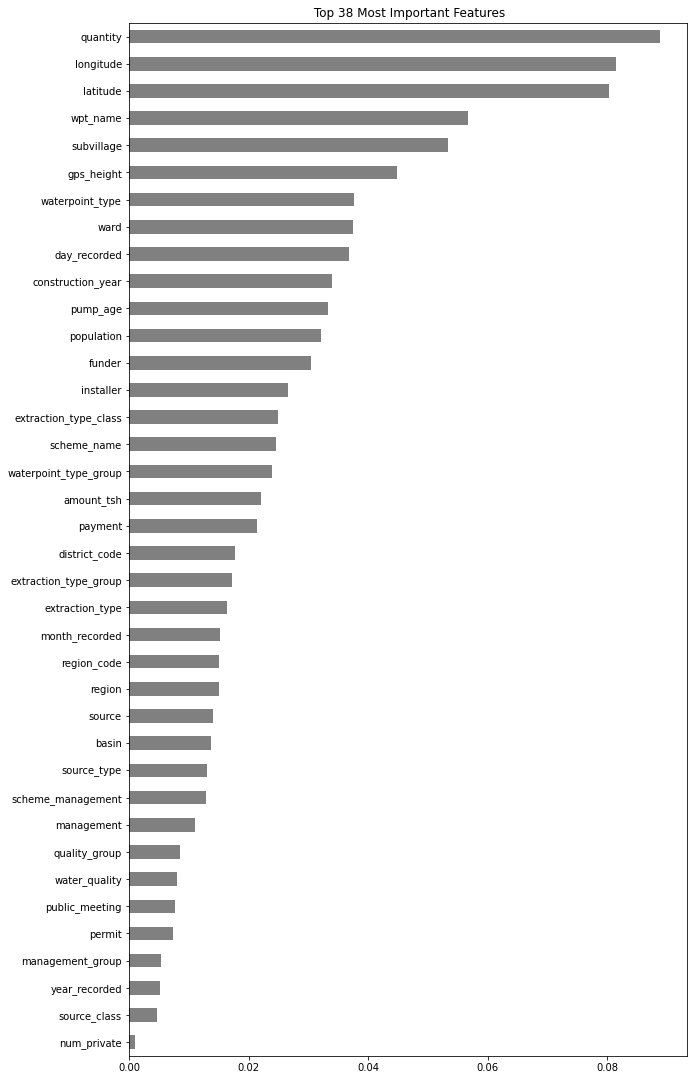

In [239]:
target = 'status_group'
features = ['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'pump_age',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name']

# X Matrix
X_train = train[features]
X_val = val[features]
X_test = test[features]

# y vector
y_train = train[target]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(max_depth = 30, criterion = 'gini', n_jobs = -1, 
                           random_state = 0)
)

pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
print('Validation Accuracy:', pipeline.score(X_val, y_val))
print('\n')

%matplotlib inline
import matplotlib.pyplot as plt

# Get Feature Importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot Top N Features Importances
n = len(features)
plt.figure(figsize = (10, n/2))
plt.title(f' Top {n} Most Important Features')
importances.sort_values()[-n:].plot.barh(color = 'grey');

In [0]:
### Formatting submission:
submission = sample_submission.copy()
submission['status_group'] = y_pred_test
submission.to_csv('submission-04.csv', index = False)

In [0]:
from google.colab import files
files.download('submission-04.csv')

Validation Accuracy: 0.8118686868686869




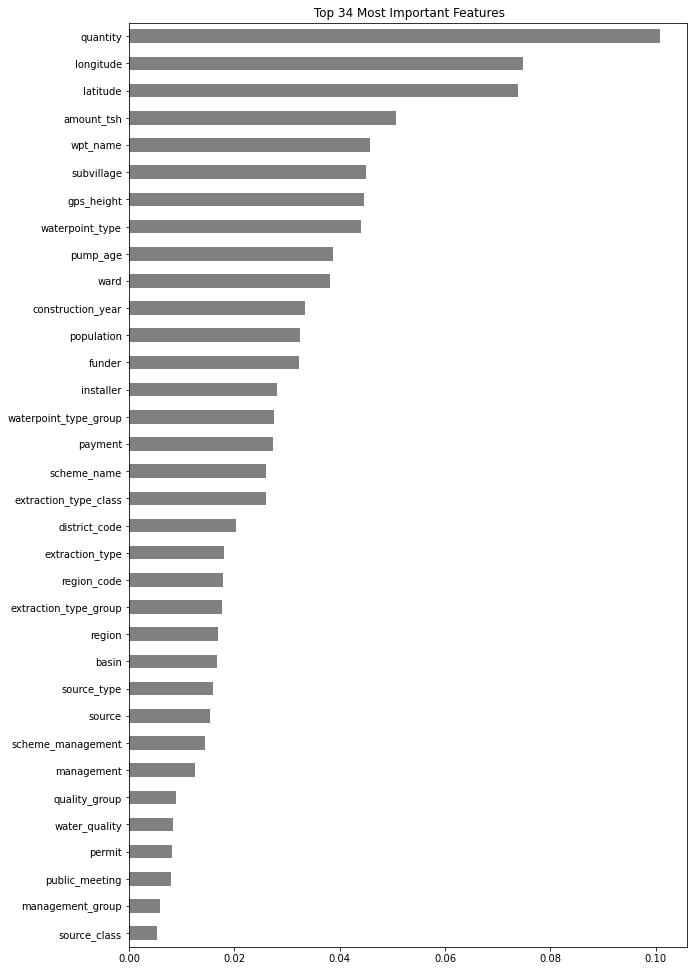

In [242]:
target = 'status_group'
features = ['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'pump_age',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name']

# X Matrix
X_train = train[features]
X_val = val[features]
X_test = test[features]

# y vector
y_train = train[target]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    IterativeImputer(missing_values = 0),
    RandomForestClassifier(n_estimators = 159, max_depth = 21, criterion = 'gini', n_jobs = -1, 
                           random_state = 0)
)

pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
print('Validation Accuracy:', pipeline.score(X_val, y_val))
print('\n')

%matplotlib inline
import matplotlib.pyplot as plt

# Get Feature Importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot Top N Features Importances
n = len(features)
plt.figure(figsize = (10, n/2))
plt.title(f' Top {n} Most Important Features')
importances.sort_values()[-n:].plot.barh(color = 'grey');

In [0]:
### Formatting submission:
submission = sample_submission.copy()
submission['status_group'] = y_pred_test
submission.to_csv('submission-05.csv', index = False)

In [0]:
from google.colab import files
files.download('submission-05.csv')

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

features = ['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'day_recorded',
 'pump_age',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name']

map_dict = {'functional':1, 'non functional':0, 'functional needs repair':.5}

X_train = train[features]
y_train = train[target].map(map_dict)

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf = 1, smoothing = 1), 
    SimpleImputer(strategy = 'mean'), 
    RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring = 'neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean Score for {k} folds', -scores.mean())

MAE for 3 folds: [0.23499694 0.23501829 0.23618854]
Mean Score for 3 folds 0.23540125736531983


In [251]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

target = 'status_group'
features = ['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'pump_age',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name']

map_dict = {'functional':1, 'non functional':0, 'functional needs repair':2}

X_train = train[features]
y_train = train[target] #.map(map_dict)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    IterativeImputer(missing_values = 0),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(0, 500),
    'randomforestclassifier__max_depth': range(0,50),
    'randomforestclassifier__max_features': range(0,35),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    cv = 2,
    scoring = 'neg_mean_absolute_error',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
)


search.fit(X_train, y_train);
estimators.get_paramas_

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min


ValueError: ignored

In [193]:
from sklearn.metrics import mean_absolute_error

print('Best Hyperparameters', search.best_params_)
print('Cross-Validation MAE', -search.best_score_)

best_estimator = search.best_estimator_
estimator_params = estimator.get_params_
print('Best Estimators', best_estimator)
print('Estimator Parameters', esimator_params)

X_val = val[features]
X_test = test[features]

y_val = val[target].map(map_dict)

y_pred = best_estimator.predict(X_val)
y_pred_test_best = best_estimator.predict(X_test)
mae = mean_absolute_error(y_val, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Best Hyperparameters {'randomforestregressor__max_depth': 21, 'randomforestregressor__max_features': 0.2740425585810261, 'randomforestregressor__n_estimators': 159, 'simpleimputer__strategy': 'median'}
Cross-Validation MAE 0.26467311159422613
Best Estimators Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type',
                                      'source_class', 'waterpoint_type',
                                      'waterpoint_t...

In [224]:
def changes(lst):
  for x in y_pred_test_best:
    if x <= .45:
      x = 'non functional'
    elif .45 < x <= .55:
      x = 'functional needs repair'
    elif x > .55:
      x = 'functional'
    
changes(y_pred_test_best)
y_pred_test_best

array([0.52830189, 0.75799266, 0.75786164, ..., 0.70787164, 0.85784447,
       0.04886309])

In [0]:
### Formatting submission:
submission = sample_submission.copy()
submission['status_group'] = y_pred_test_best
submission.to_csv('submission-06.csv', index = False)

In [0]:
from google.colab import files
files.download('submission-06.csv')